In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install openpyxl

In [3]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import tensorflow as tf
import numpy as np
from pathlib import Path
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
import matplotlib.pyplot as plt

In [4]:
sp_index = pd.read_csv("sp500_index.csv")
sp_index

,Date,S&P500
0,2014-02-18,1840.76
1,2014-02-19,1828.75
2,2014-02-20,1839.78
3,2014-02-21,1836.25
4,2014-02-24,1847.61
...,...,...
2511,2024-02-08,4997.91
2512,2024-02-09,5026.61
2513,2024-02-12,5021.84
2514,2024-02-13,4953.17


In [5]:
sp_stocks = pd.read_excel("sp500_stocks_4years.xlsx")
sp_stocks.head()


,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2020-01-02,MMM,166.588959,180.000000,180.009995,177.139999,177.679993,3601700.0
1,2020-01-03,MMM,165.154465,178.449997,178.660004,175.630005,177.020004,2466900.0
2,2020-01-06,MMM,165.311783,178.619995,178.710007,176.350006,177.149994,1998000.0
3,2020-01-07,MMM,164.645416,177.899994,178.509995,176.820007,178.279999,2173000.0
4,2020-01-08,MMM,167.172028,180.630005,181.500000,177.649994,178.000000,2758300.0


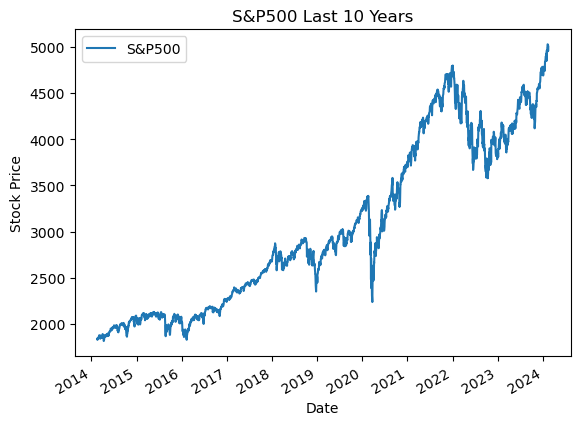

In [6]:
sp_index['Date'] = pd.to_datetime(sp_index.Date,format="%Y-%m-%d")
sp_index.index=sp_index['Date']

# Plot the data
sp_index.plot(x='Date', y='S&P500', kind='line', linestyle='-')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('S&P500 Last 10 Years')

# Show the plot
plt.show()

In [7]:
apple_df = sp_stocks[sp_stocks['Symbol'] == 'AAPL']
apple_df

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
40482,2020-01-02,AAPL,73.059410,75.087502,75.150002,73.797501,74.059998,135480400.0
40483,2020-01-03,AAPL,72.349152,74.357498,75.144997,74.125000,74.287498,146322800.0
40484,2020-01-06,AAPL,72.925644,74.949997,74.989998,73.187500,73.447502,118387200.0
40485,2020-01-07,AAPL,72.582657,74.597504,75.224998,74.370003,74.959999,108872000.0
40486,2020-01-08,AAPL,73.750252,75.797501,76.110001,74.290001,74.290001,132079200.0
...,...,...,...,...,...,...,...,...
41515,2024-02-09,AAPL,188.850006,188.850006,189.990005,188.000000,188.649994,45155200.0
41516,2024-02-12,AAPL,187.149994,187.149994,188.669998,186.789993,188.419998,41781900.0
41517,2024-02-13,AAPL,185.039993,185.039993,186.210007,183.509995,185.770004,56529500.0
41518,2024-02-14,AAPL,184.149994,184.149994,185.529999,182.440002,185.320007,54630500.0


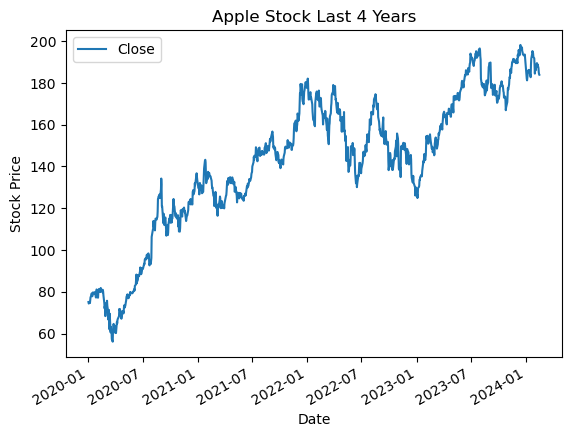

In [8]:
apple_df.plot(x='Date', y='Close', kind='line', linestyle='-')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Apple Stock Last 4 Years')

# Show the plot
plt.show()

In [9]:
apple_df.columns

Index(['Date', 'Symbol', 'Adj Close', 'Close', 'High', 'Low', 'Open',
       'Volume'],
      dtype='object')

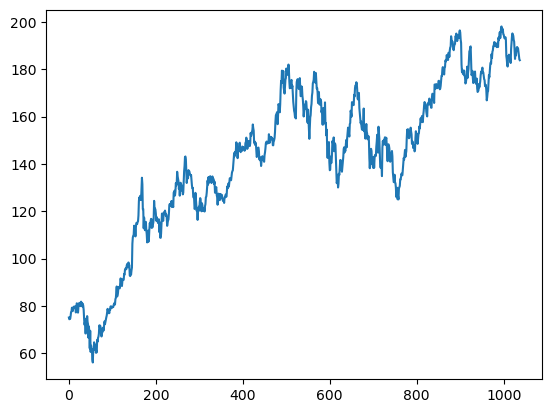

In [10]:
df2 = apple_df.reset_index()['Close']
plt.plot(df2)

In [11]:
scaler = MinMaxScaler()
df2 = scaler.fit_transform(np.array(df2).reshape(-1,1))
df2.shape

(1038, 1)

In [12]:
train_data=df2[0:1037]
valid_data=df2[1037:,]

train_size = int(len(df2)*0.80)
test_size = len(df2) - train_size
train_data,test_data = df2[0:train_size,:],df2[train_size:len(df2),:1]

In [13]:
def create_dataset(dataset, time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
                   a = dataset[i:(i+time_step),0]
                   dataX.append(a)
                   dataY.append(dataset[i + time_step,0])
    return np.array(dataX),np.array(dataY)

In [14]:
time_step = 100
X_train,Y_train =  create_dataset(train_data,time_step)
X_test,Y_test =  create_dataset(test_data,time_step)

In [15]:
# checking values
print(X_train.shape)
print(X_train)
print(X_test.shape)
print(Y_test.shape)

(729, 100)
[[0.13375114 0.1286109  0.13278292 ... 0.16279686 0.16638798 0.16258562]
 [0.1286109  0.13278292 0.13030088 ... 0.16638798 0.16258562 0.16501486]
 [0.13278292 0.13030088 0.13875052 ... 0.16258562 0.16501486 0.16526133]
 ...
 [0.66630874 0.67032227 0.64722654 ... 0.73728592 0.73235697 0.77080288]
 [0.67032227 0.64722654 0.66250633 ... 0.73235697 0.77080288 0.76833845]
 [0.64722654 0.66250633 0.66877327 ... 0.77080288 0.76833845 0.76847921]]
(107, 100)
(107,)


In [16]:
stock_model = Sequential()
stock_model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],1)))
stock_model.add(LSTM(50,return_sequences = True))
stock_model.add(LSTM(50))
stock_model.add(Dense(1))
stock_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [17]:
stock_model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 100,batch_size = 32,verbose = 1)

Epoch 1/100

23/23 [==============================] - 5s 70ms/step - loss: 0.0417 - val_loss: 0.0025
Epoch 2/100
23/23 [==============================] - 1s 36ms/step - loss: 0.0054 - val_loss: 0.0118
Epoch 3/100
23/23 [==============================] - 1s 36ms/step - loss: 0.0035 - val_loss: 0.0071
Epoch 4/100
23/23 [==============================] - 1s 36ms/step - loss: 0.0029 - val_loss: 0.0062
Epoch 5/100
23/23 [==============================] - 1s 36ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 6/100
23/23 [==============================] - 1s 36ms/step - loss: 0.0028 - val_loss: 0.0040
Epoch 7/100
23/23 [==============================] - 1s 36ms/step - loss: 0.0026 - val_loss: 0.0039
Epoch 8/100
23/23 [==============================] - 1s 36ms/step - loss: 0.0024 - val_loss: 0.0033
Epoch 9/100
23/23 [==============================] - 1s 36ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 10/100
23/23 [==============================] - 1s 36ms/step - loss: 0.0023 - val_loss: 0.009

23/23 [==============================] - 1s 36ms/step - loss: 5.6186e-04 - val_loss: 3.0663e-04
Epoch 78/100
23/23 [==============================] - 1s 37ms/step - loss: 5.5444e-04 - val_loss: 5.9665e-04
Epoch 79/100
23/23 [==============================] - 1s 36ms/step - loss: 5.6878e-04 - val_loss: 3.0821e-04
Epoch 80/100
23/23 [==============================] - 1s 37ms/step - loss: 5.7389e-04 - val_loss: 2.9455e-04
Epoch 81/100
23/23 [==============================] - 1s 36ms/step - loss: 5.4346e-04 - val_loss: 7.0560e-04
Epoch 82/100
23/23 [==============================] - 1s 37ms/step - loss: 5.7310e-04 - val_loss: 2.6903e-04
Epoch 83/100
23/23 [==============================] - 1s 36ms/step - loss: 6.0878e-04 - val_loss: 2.5655e-04
Epoch 84/100
23/23 [==============================] - 1s 36ms/step - loss: 6.5219e-04 - val_loss: 2.5652e-04
Epoch 85/100
23/23 [==============================] - 1s 36ms/step - loss: 5.5954e-04 - val_loss: 3.3803e-04
Epoch 86/100
23/23 [============

In [18]:
train_predict = stock_model.predict(X_train)
test_predict = stock_model.predict(X_test)

4/4 [==============================] - 0s 11ms/step


In [71]:
# transform to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [74]:
model_predictions = stock_model.predict(X_train)
true_labels = Y_train

23/23 [==============================] - 0s 12ms/step


In [76]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(true_labels, model_predictions)
print("Mean Absolute Error (MAE):", mae)

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(true_labels, model_predictions)
print("Mean Squared Error (MSE):", mse)

# Compute R^2 Score
r2 = r2_score(true_labels, model_predictions)
print("R^2 Score:", r2)

Mean Absolute Error (MAE): 0.020703168929908748
Mean Squared Error (MSE): 0.0006884081317323887
R^2 Score: 0.9701380426852374


In [20]:
look_back = 100

trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict

testPredictPlot = np.empty_like(df2)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back)*2 + 1 : len(df2) - 1,:] = test_predict

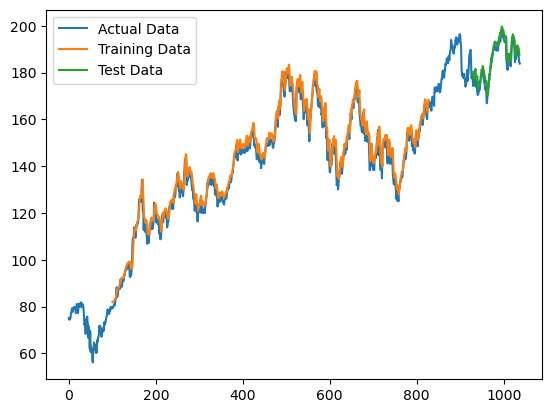

In [21]:
plt.plot(scaler.inverse_transform(df2), label="Actual Data")
plt.plot(trainPredictPlot, label="Training Data")
plt.plot(testPredictPlot, label="Test Data")

plt.legend()
plt.show()

In [22]:
X_test.shape

(107, 100)

In [58]:
# Number of future days to predict
future_days = 10
future_predictions = []
last_sequence = X_test[-1].reshape(1, -1)

for i in range(future_days):
    # Predict the next day's value with last sequence
    next_prediction = stock_model.predict(last_sequence)
    # Inverse transform to get the actual predicted value
    next_prediction = scaler.inverse_transform(next_prediction)
    # Append the prediction to the list of future predictions
    future_predictions.append(next_prediction)
    # Update last_sequence for the next prediction
    last_sequence = next_prediction.reshape(1, -1)

1/1 [==============================] - 0s 13ms/step


In [60]:
future_predictions

[array([[187.40842]], dtype=float32),
 array([[253.03203]], dtype=float32),
 array([[253.0014]], dtype=float32),
 array([[253.00143]], dtype=float32),
 array([[253.00142]], dtype=float32),
 array([[253.00143]], dtype=float32),
 array([[253.00142]], dtype=float32),
 array([[253.00143]], dtype=float32),
 array([[253.00142]], dtype=float32),
 array([[253.00143]], dtype=float32)]

In [61]:
df2 = scaler.inverse_transform(df2)
df2

array([[10719.83188422],
       [10616.15863114],
       [10700.30382761],
       ...,
       [26335.01008411],
       [26208.61459416],
       [26167.43047212]])

In [63]:
df2 = pd.DataFrame(df2)
df2 = df2[['Close']]
df2

KeyError: "None of [Index(['Close'], dtype='object')] are in the [columns]"

In [ ]:
model_data=df2[:1037]
predict_data=df2[1037:]
predict_data['Predictions']=next_prediction
predict_data

In [ ]:
### WE NEED A FOR LOOP HERE TO TAKE THE 'Predictions' ABOVE AND PUT IT IN THE 'Close' COLUMN OF THE NEXT ROW. 
### THEN USE THAT DATA TO RUN THROUGH THE MODEL AND MAKE A NEW PREDICTION. WE NEED 253 PREDICTIONS TO HAVE A FULL 
### YEAR OF TRADING DAYS